# NLP Challenge - Fake new detection

In [147]:
import pandas as pd
import numpy as np
import string
import spacy
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

### Background

We will attempt to build a classification model from this dataset from kaggle 

Data source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

It contains labeled text of fake and real new articles

### Data cleaning

In [2]:
# Load the data
fake_news_df = pd.read_csv('Fake_and_real_news/Fake.csv')
# Create a binary column for classification 
fake_news_df['fake_news'] = 1
fake_news_df

,title,text,subject,date,fake_news
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [3]:
real_news_df = pd.read_csv('Fake_and_real_news/True.csv')
real_news_df['fake_news'] = 0
real_news_df

,title,text,subject,date,fake_news
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [4]:
# Combine the two classes into a single DataFrame
news_df = real_news_df.append(fake_news_df).reset_index()
news_df

,index,title,text,subject,date,fake_news
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...,...
44893,23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


#### Tokenize, lemmatize and remove stop words and punctuation

In [5]:
from IPython.display import clear_output
nlp = spacy.load("en_core_web_sm")
def preprocess(docs):
    preprocessed = []
    total_docs = len(docs)

    for i, doc in enumerate(docs):
        clear_output(wait=True)
        print(f'Processing doc {i} of {total_docs}')
        spacy_doc = nlp(doc)
        cleaned = [token.lemma_.lower() 
                   for token in spacy_doc 
                   if not token.is_stop
                  if token.is_alpha]
        untokenized = " ".join(cleaned)
        preprocessed.append(untokenized)
    
    return preprocessed

In [7]:
preprocessed = preprocess(news_df.text)
preprocessed[0]

Processing doc 44897 of 44898


'washington reuters head conservative republican faction congress vote month huge expansion national debt pay tax cut call fiscal conservative sunday urge budget restraint keep sharp pivot way republicans representative mark meadows speak cbs face nation draw hard line federal spending lawmaker brace battle january return holiday wednesday lawmaker begin try pass federal budget fight likely link issue immigration policy november congressional election campaign approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration willing go increase non defense discretionary spending percent meadows chairman small influential house freedom caucus say program democrats say need government pay raise percent fiscal conservative rationale eventually r

In [50]:
preprocessed_df = pd.DataFrame(preprocessed)
preprocessed_df.columns = ['text']
preprocessed_df['fake_news'] = news_df.fake_news
preprocessed_df

,text,fake_news
0,washington reuters head conservative republica...,0
1,washington reuters transgend people allow time...,0
2,washington reuters special counsel investigati...,0
3,washington reuters trump campaign adviser geor...,0
4,seattle washington reuters president donald tr...,0
...,...,...
44893,century wire say report early week unlikely mi...,1
44894,century wire say s familiar theme dispute chan...,1
44895,patrick henningsen century wireremember obama ...,1
44896,century wire say al jazeera america history bi...,1


In [52]:
# some of the articles are empty
preprocessed_df.loc[preprocessed_df.text == '']

,text,fake_news
8970,,0
30775,,1
32340,,1
32458,,1
32607,,1
...,...,...
43244,,1
43274,,1
43286,,1
43287,,1


In [53]:
# set empty articles with no text to null and remove them
preprocessed_df.text.loc[preprocessed_df.text == ''] = np.nan
preprocessed_df.isnull().sum()

/Users/abilenky/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


text         716
fake_news      0
dtype: int64

In [54]:
preprocessed_df.dropna(inplace=True)

In [55]:
preprocessed_df.isnull().sum()

text         0
fake_news    0
dtype: int64

#### Preprocessing is slow so we will save the results to a file for future use

In [57]:
preprocessed_df.to_csv('Fake_and_real_news/preprocessed.csv', index=False)

### Exploratory data analysis

In [69]:
def doc_stats(doc):
    tokens = word_tokenize(doc)
    words = [token.lower() for token in tokens
            if token.lower() not in stopwords.words('english')
            if token not in string.punctuation]
    num_words = len(words)
    vocab = len(set(words))
    chars = sum([len(word) for word in words])

    spacy_doc = nlp(doc)
    remove = ['DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

    ents = [ent.text for ent in spacy_doc.ents
           if ent.label_ not in remove]

    num_ents = len(set(ents))
    chars_word = chars/num_words
    lex_div = vocab/num_words

    stats = [num_words, vocab, num_ents, chars_word, lex_div]
    return stats



In [70]:
doc_stats(preprocessed_df.text[0])

[407, 252, 29, 6.452088452088452, 0.6191646191646192]

#### It will take a long time to process all the articles again so we will look at the statistics of a random sample of 100 each from the two classes

In [81]:
fake_news_sample = preprocessed_df.loc[lambda x: x.fake_news == 1].sample(100)
fake_news_sample

,text,fake_news
44011,special report savvy neocon hillary clinton tr...,1
42005,challenge pose great threat future generation ...,1
41897,strategy left war s american hear angela davis...,1
22916,fact country despise donald trump vote secret ...,1
34235,reckless hillary couldn t care seriousness exp...,1
...,...,...
28360,mississippi republicans worry billion federal ...,1
32877,immigrant have grow communist society know val...,1
25055,donald trump attack amendment tuesday george t...,1
25740,year old marley dias want woman president work...,1


In [82]:
real_news_sample = preprocessed_df.loc[lambda x: x.fake_news == 0].sample(100)
real_news_sample

,text,fake_news
9135,reuters detroit sell general obligation bond e...,0
10703,washington reuters key senator say tuesday cra...,0
12355,istanbul reuters muslim leader wednesday conde...,0
5014,washington reuters president donald trump ask ...,0
597,washington reuters pataskala ohio conroe texas...,0
...,...,...
6585,honolulu reuters president barack obama friday...,0
89,washington reuters steny hoyer democrat house ...,0
20868,tunis reuters tunisian prime minister youssef ...,0
15305,brasilia reuters congressional committee lead ...,0


In [83]:
columns = ['Number of words', 'Vocabulary', 'Number of Named Entities',
          'Avg word length', 'Lexical diversity']
stats_real_news = [doc_stats(doc) for doc in real_news_sample.text]
stats_real_df = pd.DataFrame(stats_real_news, columns=columns)
stats_real_df

,Number of words,Vocabulary,Number of Named Entities,Avg word length,Lexical diversity
0,162,103,9,5.987654,0.635802
1,216,142,15,5.925926,0.657407
2,428,245,46,6.698598,0.572430
3,224,153,25,6.348214,0.683036
4,449,269,36,6.320713,0.599109
...,...,...,...,...,...
95,231,160,17,6.839827,0.692641
96,45,38,8,6.377778,0.844444
97,25,23,4,6.520000,0.920000
98,146,114,10,6.849315,0.780822


In [84]:
stats_fake_news = [doc_stats(doc) for doc in fake_news_sample.text]
stats_fake_df = pd.DataFrame(stats_fake_news, columns=columns)
stats_fake_df

,Number of words,Vocabulary,Number of Named Entities,Avg word length,Lexical diversity
0,445,302,58,6.417978,0.678652
1,719,399,22,6.216968,0.554937
2,213,169,23,6.403756,0.793427
3,162,114,6,5.604938,0.703704
4,350,218,29,6.285714,0.622857
...,...,...,...,...,...
95,170,123,15,6.323529,0.723529
96,61,57,8,6.459016,0.934426
97,191,125,8,6.094241,0.654450
98,245,153,13,5.355102,0.624490


In [85]:
stats_fake_df.describe()

,Number of words,Vocabulary,Number of Named Entities,Avg word length,Lexical diversity
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,215.840000,146.600000,15.830000,6.010385,0.721234
std,161.085128,96.323739,12.899029,0.378032,0.104650
min,7.000000,7.000000,0.000000,5.000000,0.524272
25%,131.500000,94.250000,9.750000,5.793408,0.653716
50%,202.000000,140.000000,14.500000,5.982971,0.705974
75%,270.000000,182.500000,20.000000,6.253934,0.767446
max,1294.000000,769.000000,108.000000,7.260870,1.000000


In [86]:
stats_real_df.describe()

,Number of words,Vocabulary,Number of Named Entities,Avg word length,Lexical diversity
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,230.880000,150.840000,20.050000,6.303509,0.703593
std,178.813445,99.700331,13.731461,0.328998,0.091640
min,24.000000,20.000000,2.000000,5.460000,0.510757
25%,99.500000,78.500000,10.000000,6.106724,0.637352
50%,199.000000,138.000000,17.000000,6.300685,0.694146
75%,305.250000,209.750000,25.000000,6.469007,0.760184
max,1255.000000,641.000000,80.000000,7.464286,0.930233


#### Lets look at the term frequency distribution of those samples 

In [87]:
from nltk.probability import FreqDist

In [113]:
fake_news_sample_combined = " ".join(fake_news_sample.text)
fake_news_sample_combined = [word for word in word_tokenize(fake_news_sample_combined) if len(word) > 1]
fdist_fake_news = FreqDist(fake_news_sample_combined)
fdist_fake_news

FreqDist({'trump': 344, 'say': 184, 'president': 121, 'people': 120, 'clinton': 91, 'year': 84, 'obama': 83, 'like': 82, 'time': 76, 'go': 74, ...})

In [114]:
fake_news_fdist_df = pd.DataFrame.from_dict(fdist_fake_news, orient='index').reset_index()
fake_news_fdist_df.columns = ['term', 'freq']

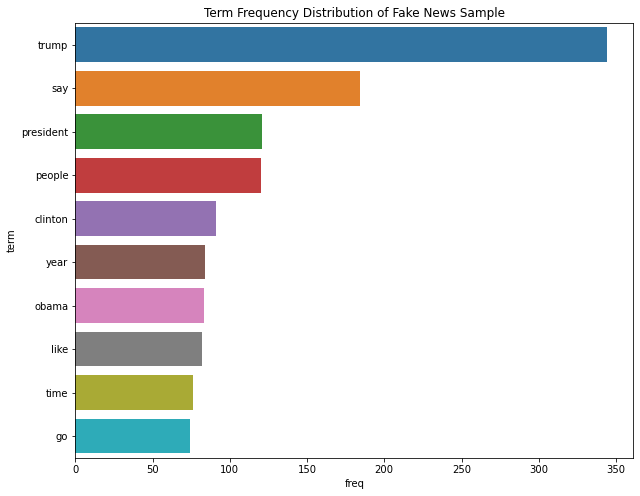

In [126]:
plt.figure(figsize=(10,8))
sns.barplot(data=fake_news_fdist_df.sort_values(by='freq', ascending=False).head(10), 
            y='term', x='freq')
plt.title('Term Frequency Distribution of Fake News Sample')
plt.show()

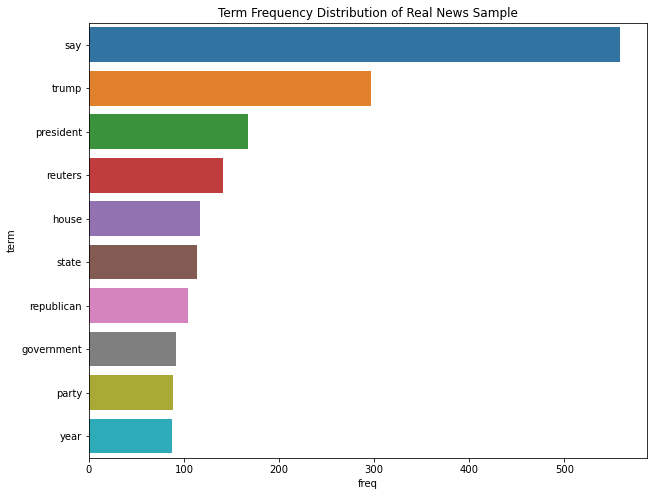

In [127]:
real_news_sample_combined = " ".join(real_news_sample.text)
real_news_sample_combined = [word for word in word_tokenize(real_news_sample_combined) if len(word) > 1]
fdist_real_news = FreqDist(real_news_sample_combined)

real_news_fdist_df = pd.DataFrame.from_dict(fdist_real_news, orient='index').reset_index()
real_news_fdist_df.columns = ['term', 'freq']

plt.figure(figsize=(10,8))
sns.barplot(data=real_news_fdist_df.sort_values(by='freq', ascending=False).head(10), 
            y='term', x='freq')
plt.title('Term Frequency Distribution of Real News Sample')
plt.show()

### Convert your text features into numerical form

In [129]:
# first we'll try TF-IDF
vectorizer = TfidfVectorizer()

vectorized = vectorizer.fit_transform(preprocessed_df.text)

In [130]:
vectorized

<44182x86561 sparse matrix of type '<class 'numpy.float64'>'
	with 6230068 stored elements in Compressed Sparse Row format>

### Build classification model

In [131]:
X_train, X_test, y_train, y_test = train_test_split(vectorized, preprocessed_df.fake_news, 
                                                    test_size=0.2)

In [135]:
# Let's try a Random forest classifier
rfc = RandomForestClassifier(verbose=1, n_jobs=-1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.7s finished


RandomForestClassifier(n_jobs=-1, verbose=1)

In [137]:
y_test_pred = rfc.predict(X_test)
print(classification_report(y_test, y_test_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4290
           1       0.99      0.99      0.99      4547

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [139]:
scores = cross_val_score(rfc, vectorized, preprocessed_df.fake_news, cv=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]:

In [141]:
scores.mean()

0.984789768982882

With TF-IDF and the random forest classifier we are getting an average cross validated accuracy of 98%

Let's see how a logistic regression model performs 

In [144]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(verbose=1, n_jobs=-1)
logit.fit(X_train, y_train)

y_test_pred = logit.predict(X_test)
print(classification_report(y_test, y_test_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4290
           1       0.99      0.98      0.99      4547

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


In [145]:
scores = cross_val_score(logit, vectorized, preprocessed_df.fake_news, cv=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

In [146]:
scores.mean()

0.9772300944182039

Not too bad. Lets try the same models but using a count vectorizer instead

In [148]:
vectorizer = CountVectorizer()

vectorized = vectorizer.fit_transform(preprocessed_df.text)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(vectorized, preprocessed_df.fake_news, 
                                                    test_size=0.2)

In [150]:
rfc = RandomForestClassifier(verbose=1, n_jobs=-1)
rfc.fit(X_train, y_train)

y_test_pred = rfc.predict(X_test)
print(classification_report(y_test, y_test_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4311
           1       0.99      0.99      0.99      4526

    accuracy                           0.99      8837
   macro avg       0.99      0.99      0.99      8837
weighted avg       0.99      0.99      0.99      8837



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [151]:
scores = cross_val_score(rfc, vectorized, preprocessed_df.fake_news, cv=10)
scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]:

0.9846765341357452

In [152]:
logit = LogisticRegression(verbose=1, n_jobs=-1)
logit.fit(X_train, y_train)

y_test_pred = logit.predict(X_test)
print(classification_report(y_test, y_test_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4311
           1       0.99      1.00      1.00      4526

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished


In [153]:
scores = cross_val_score(logit, vectorized, preprocessed_df.fake_news, cv=10)
scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

0.9936398608379736

### Results

Looks like the best results are from the logistic regression model trained on the count vectorized data.